In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import chi2_contingency, ks_2samp, chisquare, poisson

In [18]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
DRIVER_GENES = "../data/driver_genes"

# output files/dir
PASSENGER_DENSITY_BY_CANCER = "../results/passenger_density_by_cancer"
PASSENGER_FREQUENCY_DIST = "../results/passenger_frequency_distribution"

if not os.path.exists(PASSENGER_DENSITY_BY_CANCER):
	os.makedirs(PASSENGER_DENSITY_BY_CANCER)

if not os.path.exists(PASSENGER_FREQUENCY_DIST):
	os.makedirs(PASSENGER_FREQUENCY_DIST)

In [21]:
cancer_type = "Liver-HCC"

In [22]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [24]:
# genome-wide mutations
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
genome_wide_mutations.head()

,Tumor_Sample_Barcode,total_mutations,num_drivers,cancer_type,cna_burden
0,00493087-9d9d-40ca-86d5-936f1b951c93,2778,5,CNS-Oligo,17.324180
1,2aeaab9f-4459-4be8-91e7-e0746cbd671c,3388,4,CNS-Oligo,19.993935
2,3a81f733-b3a3-4578-b925-a663612bc92c,2489,2,CNS-Oligo,17.647446
3,3d477ac1-3bdf-4410-9594-1a3a1412c6ae,5801,3,CNS-Oligo,24.948595
4,4853fd17-7214-4f0c-984b-1be0346ca4ab,2004,2,CNS-Oligo,9.704638


In [25]:
# get all mutations in driver genes
mut_df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
mut_df = pd.merge(mut_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
mut_df.head()

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length
0,ARID1A,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:27077925-27077925:A:G,1:27077925:A:G,False,None,False,intronic,-0.316733,0.400,86072
1,SETDB1,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150909417-150909417:A:G,1:150909417:A:G,False,mutational,True,intronic,0.110056,3.182,38475
2,SETDB1,+,Missense_Mutation,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150933317-150933317:A:C,1:150933317:A:C,True,mutational,True,exonic,5.224169,27.700,38475
3,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46151744-46151744:A:T,12:46151744:A:T,False,None,False,intronic,0.872451,11.090,178376
4,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46259757-46259757:T:G,12:46259757:T:G,False,None,False,intronic,-0.196762,0.710,178376


In [26]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

(6275, 14)
(6043, 14)


In [27]:
# passenger density for each gene in each sample
passenger_density = mut_df.groupby(["Tumor_Sample_Barcode", "gene"]).agg({
    "has_driver": "first",
    "driver": lambda x: x.value_counts().get(False, 0),
    "gene_length": "first"
}).reset_index()
passenger_density = passenger_density.rename(columns={"driver": "passenger_count"})
# adjust for genome-wide mutation rate, cna burden and gene length
print(passenger_density.shape, genome_wide_mutations.shape)
passenger_density = pd.merge(passenger_density, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
passenger_density["cna_burden"] = passenger_density["cna_burden"] / 100 # convert from percentage to fraction
print(passenger_density.shape)
# mutation rate = total mutations / genome size
# expected rate in gene = mutation rate * gene length
# adjusted mut (adjusting for genome-wide mutation rate) = mut / expected rate in gene = total mutations * genome size / (total mutations * gene length)
# adjusted mut (adjusting for cna burden) = adjusted mut / cna_burden = total mutations * genome size / (total mutations * gene length * cna_burden)
passenger_density["adj_passenger_density"] = passenger_density["passenger_count"] * 3.2e9 / (passenger_density["total_mutations"] * passenger_density["gene_length"] * passenger_density["cna_burden"])
passenger_density = passenger_density[["Tumor_Sample_Barcode", "gene", "has_driver", "passenger_count", "adj_passenger_density", "total_mutations", "cna_burden", "gene_length"]]
passenger_density.head()

(1334, 5) (2778, 5)
(1334, 9)


,Tumor_Sample_Barcode,gene,has_driver,passenger_count,adj_passenger_density,total_mutations,cna_burden,gene_length
0,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,1,2.611627,15823,0.558139,138742
1,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,1,4.209759,15823,0.558139,86072
2,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID2,False,2,4.062681,15823,0.558139,178376
3,0040b1b6-b07a-4b6e-90ef-133523eaf412,CSMD3,False,11,3.282703,15823,0.558139,1214172
4,0040b1b6-b07a-4b6e-90ef-133523eaf412,CTNNB1,False,1,5.552289,15823,0.558139,65260


In [28]:
# add rows for samples with no mutations in driver genes
tumors = passenger_density["Tumor_Sample_Barcode"].unique()
for tumor in tumors:
	for gene in driver_genes_list:
		if len(passenger_density[(passenger_density["Tumor_Sample_Barcode"] == tumor) & (passenger_density["gene"] == gene)]) == 0:
			passenger_density = pd.concat([passenger_density, pd.DataFrame({
				"Tumor_Sample_Barcode": [tumor], 
				"gene": [gene], 
				"has_driver": [False], 
				"adj_passenger_density": [0],
				"passenger_count": [0],
				"total_mutations": [0],
				"cna_burden": [0],
				"gene_length": [driver_genes[driver_genes["gene"] == gene]["gene_length"].values[0]],
			})])
print(passenger_density.shape)
passenger_density.head()

(4082, 8)


,Tumor_Sample_Barcode,gene,has_driver,passenger_count,adj_passenger_density,total_mutations,cna_burden,gene_length
0,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,1,2.611627,15823,0.558139,138742
1,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,1,4.209759,15823,0.558139,86072
2,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID2,False,2,4.062681,15823,0.558139,178376
3,0040b1b6-b07a-4b6e-90ef-133523eaf412,CSMD3,False,11,3.282703,15823,0.558139,1214172
4,0040b1b6-b07a-4b6e-90ef-133523eaf412,CTNNB1,False,1,5.552289,15823,0.558139,65260


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test smaller, P_val:3.634e-05 U_stat=5.151e+05


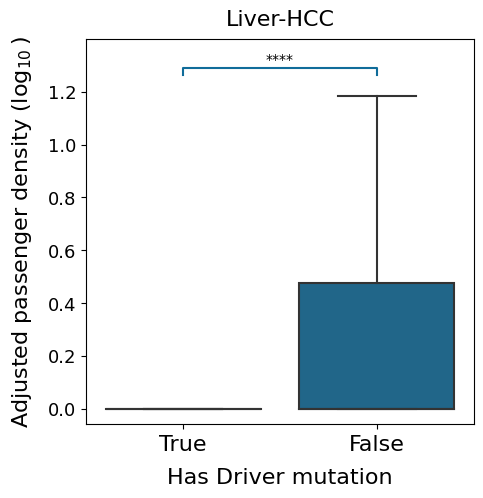

In [36]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))

plt.figure(figsize=(5, 5))
ax = sns.boxplot(
    x="has_driver",
    y="passenger_density_log",
    data=passenger_density,
    order=[True, False],
    palette=cmap,
    showfliers=False,
)
# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=passenger_density, 
    x="has_driver",
    y="passenger_density_log", 
    pairs=[(True, False)],
    order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xlabel("Has Driver mutation", fontsize=16, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=13)
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=16, labelpad=10)
plt.title(cancer_type, fontsize=16, pad=10)
plt.savefig(f"{PASSENGER_DENSITY_BY_CANCER}/{cancer_type}.png", dpi=300, bbox_inches="tight")

[(('APC', True), ('APC', False)), (('ARID1A', True), ('ARID1A', False)), (('ARID2', True), ('ARID2', False)), (('AXIN1', True), ('AXIN1', False)), (('CTNNB1', True), ('CTNNB1', False)), (('KEAP1', True), ('KEAP1', False)), (('NFE2L2', True), ('NFE2L2', False)), (('RB1', True), ('RB1', False)), (('SETDB1', True), ('SETDB1', False)), (('TERT', True), ('TERT', False)), (('TP53', True), ('TP53', False))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



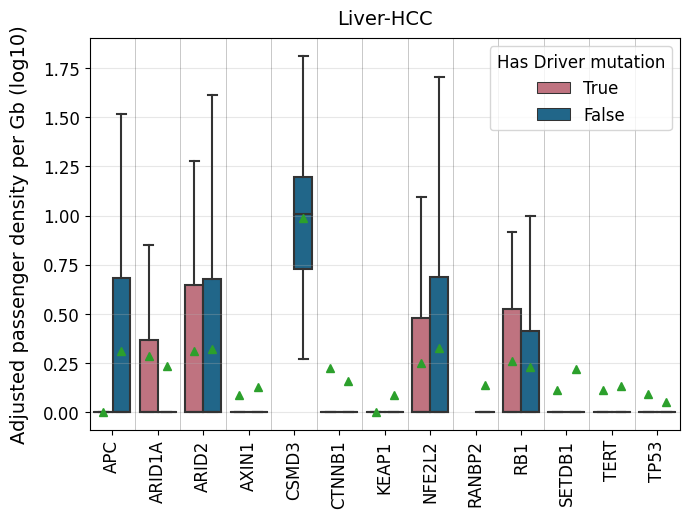

In [ ]:
# distribution of passenger mutation density by gene
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
genes = passenger_density["gene"].unique().tolist()
genes.sort()
plot_len = min(7, len(genes))
plt.figure(figsize=(plot_len, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="gene",
    y="passenger_density_log",
    hue="has_driver",
    data=passenger_density,
    palette=cmap,
    order=genes,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(genes) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for gene in genes:
    gene_data = passenger_density[passenger_density["gene"] == gene]
    if len(gene_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((gene, True), (gene, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="gene", 
    y="passenger_density_log", 
    hue="has_driver",
    pairs=box_pairs,
    order=genes,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

# change x tick labels
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])

plt.xticks(rotation=90, fontsize=12)
plt.xlabel("")
plt.ylabel("Adjusted passenger density per Gb (log10)", fontsize=14, labelpad=10)
plt.yticks(fontsize=12)
plt.legend(title="Has Driver mutation", title_fontsize=12, fontsize=12, loc='upper right')
plt.title(cancer_type, fontsize=14, pad=10)
plt.tight_layout()
plt.savefig(f"{PASSENGER_DENSITY_BY_CANCER}/{cancer_type}_gene.png", dpi=300)

## Difference in observed and expected frequencies

In [30]:
upper_limit = 10
passenger_counts = passenger_density[["has_driver", "passenger_count"]].copy()
passenger_counts = passenger_counts[passenger_counts["passenger_count"] <= upper_limit]
passenger_counts.head()

,has_driver,passenger_count
0,False,1
1,False,1
2,False,2
4,False,1
5,False,1


In [31]:
# chi-square test

# all samples
print("All samples")
observed = pd.crosstab(
    passenger_counts["has_driver"],
    passenger_counts["passenger_count"],
)
print(observed)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")
print(expected)

All samples
passenger_count    0    1    2   3   4   5   6   7   8   9   10
has_driver                                                     
False            2748  554  126  39  17  10  10   9  18  15  21
True              255   35   11   2   2   0   0   0   0   0   0
p-value: 0.25954451510392856, stat: 12.394126282436913
[[2.76645170e+03 5.42604081e+02 1.26208419e+02 3.77704029e+01
  1.75033574e+01 9.21229339e+00 9.21229339e+00 8.29106405e+00
  1.65821281e+01 1.38184401e+01 1.93458161e+01]
 [2.36548295e+02 4.63959194e+01 1.07915806e+01 3.22959711e+00
  1.49664256e+00 7.87706612e-01 7.87706612e-01 7.08935950e-01
  1.41787190e+00 1.18155992e+00 1.65418388e+00]]


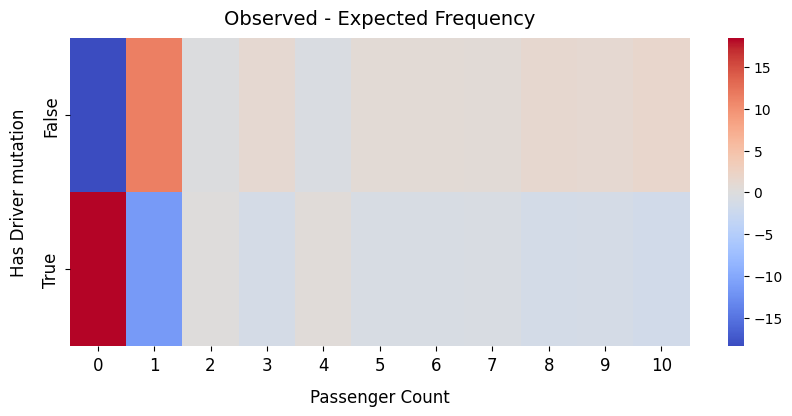

,0,1,2,3,4,5,6,7,8,9,10
False,-18.451705,11.395919,-0.208419,1.229597,-0.503357,0.787707,0.787707,0.708936,1.417872,1.18156,1.654184
True,18.451705,-11.395919,0.208419,-1.229597,0.503357,-0.787707,-0.787707,-0.708936,-1.417872,-1.18156,-1.654184


In [32]:
expected_df = pd.DataFrame(expected, columns=observed.columns, index=observed.index)
expected_df = expected_df.rename_axis(index=None, columns=None)
observed_df = pd.DataFrame(observed, columns=observed.columns, index=observed.index)
observed_df = observed_df.rename_axis(index=None, columns=None)

# get the difference between observed and expected for corresponding cells
residuals = observed_df - expected_df
plt.figure(figsize=(10, 4))
sns.heatmap(residuals, cmap='coolwarm', center=0)
plt.title("Observed - Expected Frequency", fontsize=14, pad=10)
plt.xlabel("Passenger Count", fontsize=12, labelpad=10)
plt.xticks(fontsize=12)
plt.ylabel("Has Driver mutation", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.show()
residuals

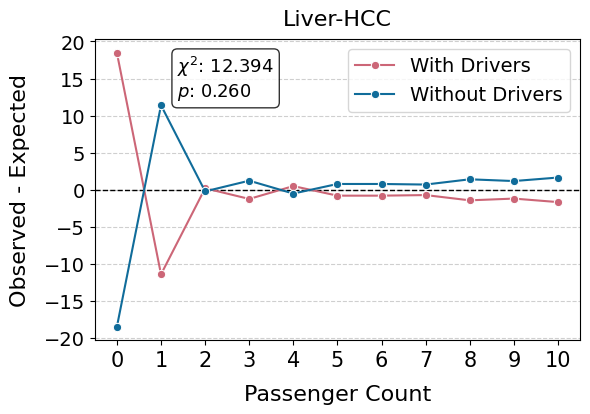

In [35]:
plt.figure(figsize=(6, 4))

# horizontal line at y=0
plt.axhline(0, color='black', lw=1, ls='--')

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[True],
	color=colors[0],
	label="With Drivers",
	marker="o",
)

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[False],
	color=colors[1],
	label="Without Drivers",
	marker="o",
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.ylabel("Observed - Expected", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.title(cancer_type, fontsize=16, pad=10)
plt.savefig(f"{PASSENGER_FREQUENCY_DIST}/{cancer_type}.png", dpi=300, bbox_inches="tight")